In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [82]:
#loading model
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1000, shuffle=False)

In [83]:
#simple NN
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [84]:
#LeNet-style CNN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))        # (N, 6, 24, 24)
        x = F.max_pool2d(x, 2)           # (N, 6, 12, 12)
        x = F.relu(self.conv2(x))        # (N, 16, 8, 8)
        x = F.max_pool2d(x, 2)           # (N, 16, 4, 4)
        x = x.view(-1, 16 * 4 * 4)       # flatten to (N, 256)
        x = F.relu(self.fc1(x))          # (N, 120)
        x = F.relu(self.fc2(x))          # (N, 84)
        x = self.fc3(x)                  # (N, 10)
        return x

In [85]:
def train(model, train_loader, optimizer, criterion, epoch, train_losses, train_accuracies):
    model.train()
    correct = 0
    total = 0
    loss_sum = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)

    avg_loss = loss_sum / len(train_loader)
    accuracy = 100. * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    print(f"Epoch {epoch}: Loss={avg_loss:.4f}, Accuracy={accuracy:.2f}%")

In [86]:
def test(model, test_loader):
    model.eval()
    correct = 0
    all_preds, all_targets = [], []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    test_accuracy = 100. * correct / len(test_loader.dataset)
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    return all_preds, all_targets


In [103]:
#training CNN
# model = NN().to(device)
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses = []
train_accuracies = []

for epoch in range(1, 11):  # 10 epochs
    train(model, train_loader, optimizer, criterion, epoch, train_losses, train_accuracies)


Epoch 1: Loss=0.2282, Accuracy=93.01%
Epoch 2: Loss=0.0684, Accuracy=97.88%
Epoch 3: Loss=0.0483, Accuracy=98.45%
Epoch 4: Loss=0.0401, Accuracy=98.64%
Epoch 5: Loss=0.0336, Accuracy=98.93%
Epoch 6: Loss=0.0271, Accuracy=99.13%
Epoch 7: Loss=0.0226, Accuracy=99.27%
Epoch 8: Loss=0.0204, Accuracy=99.32%
Epoch 9: Loss=0.0179, Accuracy=99.41%
Epoch 10: Loss=0.0165, Accuracy=99.43%


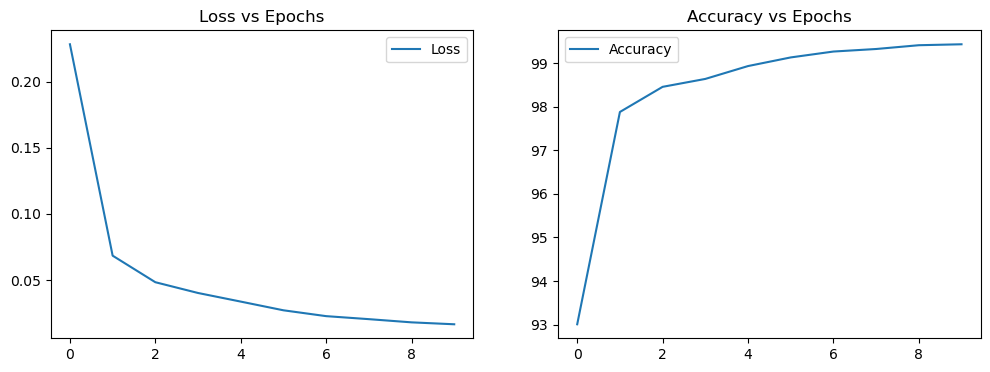

In [105]:
#ploting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Loss')
plt.title('Loss vs Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.savefig("plotsCNN.png")
plt.show()

Test Accuracy: 98.86%


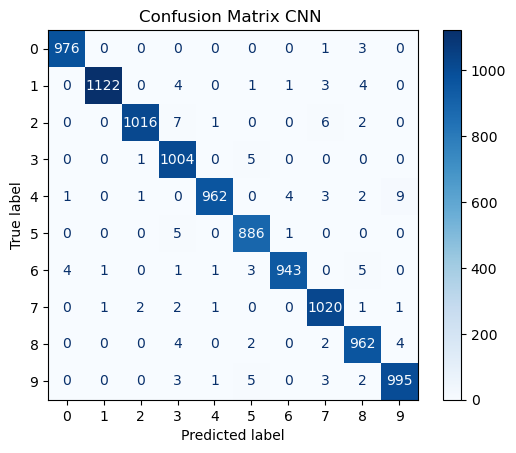

In [98]:
#confusion matrix
preds, targets = test(model, test_loader)

cm = confusion_matrix(targets, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix CNN ")
plt.savefig("ConfusionMatrix_CNN.png")
plt.show()


In [90]:
#saving trained model
torch.save(model.state_dict(), "mnist_CNN_model.pth")
print("Model saved as mnist_CNN_model.pth")

Model saved as mnist_CNN_model.pth


In [ ]:
#training NN
model1 = NN().to(device)
# model = Net().to(device)
optimizer = optim.Adam(model1.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses = []
train_accuracies = []

for epoch in range(1, 11):  # 10 epochs
    train(model1, train_loader, optimizer, criterion, epoch, train_losses, train_accuracies)


Epoch 1: Loss=0.2708, Accuracy=92.07%
Epoch 2: Loss=0.1123, Accuracy=96.50%
Epoch 3: Loss=0.0780, Accuracy=97.58%
Epoch 4: Loss=0.0604, Accuracy=98.08%
Epoch 5: Loss=0.0502, Accuracy=98.36%
Epoch 6: Loss=0.0412, Accuracy=98.63%
Epoch 7: Loss=0.0341, Accuracy=98.83%
Epoch 8: Loss=0.0303, Accuracy=99.00%
Epoch 9: Loss=0.0262, Accuracy=99.11%
Epoch 10: Loss=0.0237, Accuracy=99.18%


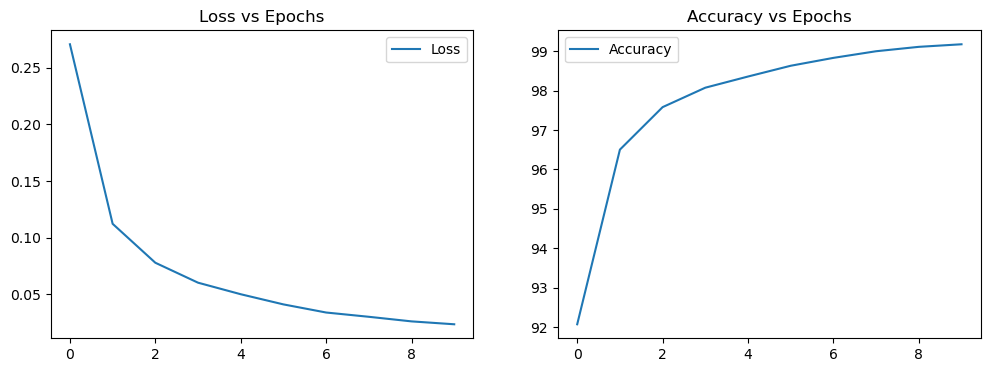

In [102]:
#ploting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Loss')
plt.title('Loss vs Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.savefig("plotsNN.png")
plt.show()

Test Accuracy: 97.80%


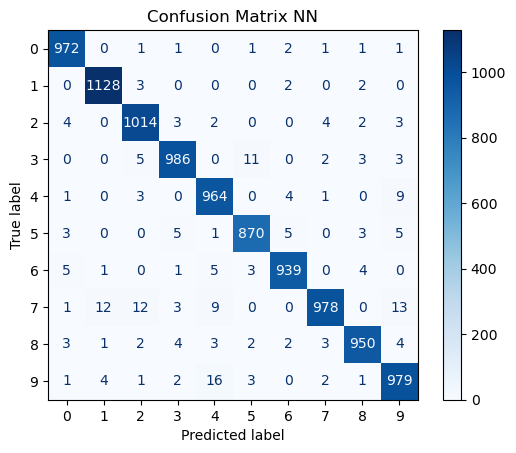

In [106]:
#confusion matrix
preds, targets = test(model1, test_loader)

cm = confusion_matrix(targets, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix NN")
plt.savefig("ConfusionMatrix_NN.png")

plt.show()


In [94]:
#saving trained model
torch.save(model.state_dict(), "mnist_NN_model.pth")
print("Model saved as mnist_NN_model.pth")

Model saved as mnist_NN_model.pth


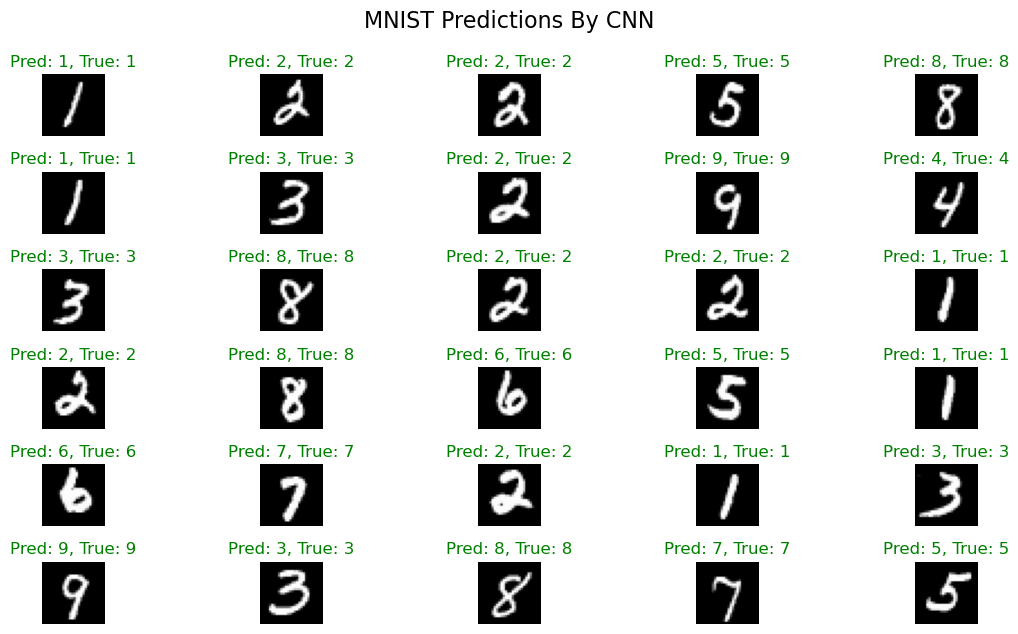

In [95]:
import matplotlib.pyplot as plt
import random

model.eval()

batch = random.choice(list(test_loader))
images, labels = batch
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

images = images.cpu()
preds = preds.cpu()
labels = labels.cpu()

plt.figure(figsize=(12, 6))
for i in range(30):
    plt.subplot(6, 5, i + 1)
    plt.imshow(images[i][0], cmap="gray")
    plt.title(f"Pred: {preds[i].item()}, True: {labels[i].item()}", 
              color="green" if preds[i] == labels[i] else "red")
    plt.axis("off")

plt.tight_layout()
plt.suptitle("MNIST Predictions By CNN", y=1.05, fontsize=16)
plt.show()


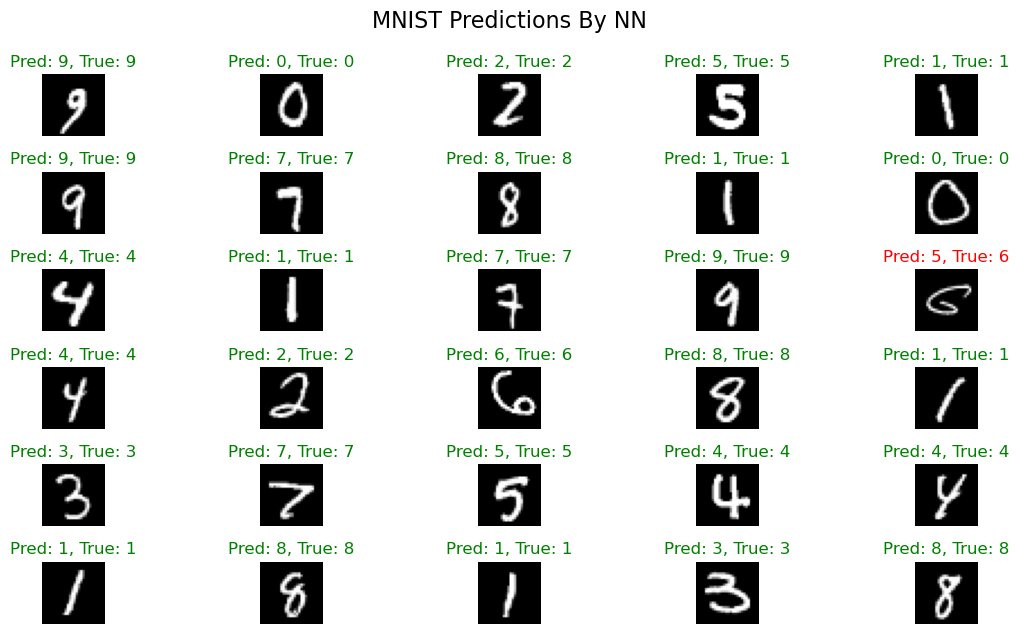

In [96]:
import matplotlib.pyplot as plt
import random

model1.eval()

batch = random.choice(list(test_loader))
images, labels = batch
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model1(images)
    preds = outputs.argmax(dim=1)

images = images.cpu()
preds = preds.cpu()
labels = labels.cpu()

plt.figure(figsize=(12, 6))
for i in range(30):
    plt.subplot(6, 5, i + 1)
    plt.imshow(images[i][0], cmap="gray")
    plt.title(f"Pred: {preds[i].item()}, True: {labels[i].item()}", 
              color="green" if preds[i] == labels[i] else "red")
    plt.axis("off")

plt.tight_layout()
plt.suptitle("MNIST Predictions By NN", y=1.05, fontsize=16)
plt.show()
